# Рекомендация тарифов

## Введение
Многие клиенты компании продолжают использовать тарифы, ставшие архивными. Наша задача - изучить пользовательское поведение клиентов, перешедших на актуальные тарифы, для того, чтобы предложить клиентам с архивными тарифами наиболее интересные им активные тарифы. 

В нашем распоряжении данные по количеству потраченных минут, отправленных сообщений и объему использованного трафика клиентов с актуальными тарифами. А также признак использования тарифа "Смарт" или "Ультра". 

Предобработка данных выполнена ранее, поэтому выполним анализ данных без этого этапа. 

# Изучение данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

В нашем распоряжении 3214 записей пользовательского поведения. 
Также, видим, что количество пользовтелей тарифа ультра приблизительно в два раза меньше, чем пользователей тарифа смарт.
Предобработка данных выполнена. 

## Создание обучающих, тестовой и валидационных выборок данных

Разделим выборки на обучающую, тестовую и валидационную в пропорциях 3:1:1

In [5]:
features = df.drop(columns = ['is_ultra'])
target = df['is_ultra']

# Делим выборку на обучающую и тестовую + валидационную
features_train, features_test_valid, target_train, target_test_valid = train_test_split(features, target, random_state = 12345, test_size = 0.4, stratify = target)
# Разделяем тестовую и валидационные выборки
features_valid, features_test, target_valid, target_test = train_test_split (features_test_valid, target_test_valid, random_state = 12345, test_size = 0.5, stratify = target_test_valid)

print ('Размер обучающей выборки', features_train.shape[0])
print ('Размер валидационной выборки', features_valid.shape[0])
print ('Размер валидационной выборки', features_test.shape[0])

Размер обучающей выборки 1928
Размер валидационной выборки 643
Размер валидационной выборки 643


## Исследование моделей

Наше исследование - задача классификации. В качестве показателя качества модели будем использовать `accuracy` обученной модели.
Рассмотрим три способа обучения: 
1. DecisionTreeClassification
2. RandomForestClassification
3. LogisticRegression
</p>Для каждого из них проверим различные значения гиперпараметров, чтобы выбрать наиболее оптимальный способ обучения, далее выберем способ, с оптимальным соотношением по значению `accuracy` и временем обработки данных. 

DecisionTreeClassifier лучший результат: 0.7853810264385692 с глубиной дерева: 5 DecisionTreeClassifier(max_depth=5, random_state=12345)


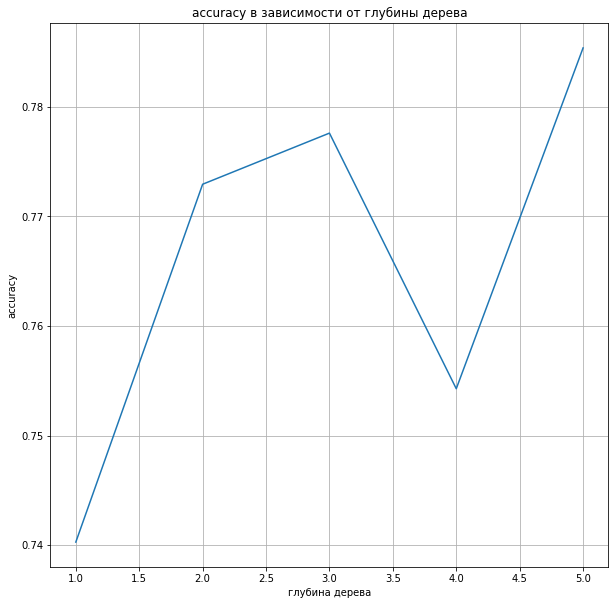

In [6]:
best_result = 0
best_depth = 0
best_model_tree = None
depth_values = []
results = []

for d in range(1,6):
    model_tree = DecisionTreeClassifier(random_state = 12345, max_depth = d)
    model_tree.fit(features_train, target_train)
    predicted_values = model_tree.predict(features_valid)
    result = accuracy_score(predicted_values, target_valid)
    depth_values.append(d)
    results.append(result)
    if result > best_result:
        best_result = result
        best_model_tree = model_tree
        best_depth = d
print ('DecisionTreeClassifier лучший результат:', best_result, 'с глубиной дерева:', best_depth, best_model_tree)

plt.figure(figsize=(10, 10))
plt.grid()
plt.title('accuracy в зависимости от глубины дерева')
plt.xlabel('глубина дерева')
plt.ylabel('accuracy')
plt.plot(depth_values, results)
plt.show()


Из всех моделей дерева принятия решений, лучший рещультат по точности дает дерево с глубиной - 3. Значение accuracy = 0.785

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=12345) accuracy= 0.8009331259720062


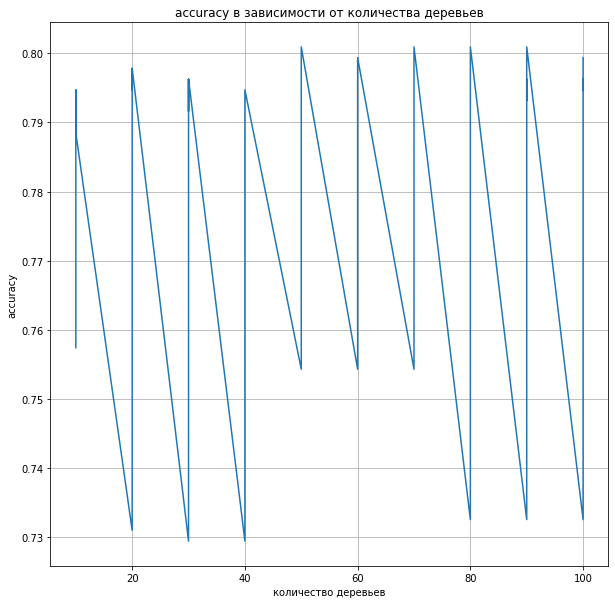

In [7]:
best_result = 0
best_depth = 0
best_est = 0
best_model_forest = None
forest_depth = []
forest_estimators = []
forest_accuracy =[]


for e in range(10,101,10):
    for d in range (1,6):
        model_forest = RandomForestClassifier(random_state = 12345, n_estimators = e, max_depth = d)
        model_forest.fit(features_train, target_train)
        predicted_values = model_forest.predict(features_valid)
        result = accuracy_score(predicted_values, target_valid)
        forest_depth.append(d)
        forest_estimators.append(e)
        forest_accuracy.append(result)
        if result > best_result:
            best_result = result
            best_depth = d
            best_est = e
            best_model_forest = model_forest
print (best_model_forest, 'accuracy=',best_result)

plt.figure(figsize=(10, 10))
plt.grid()
plt.title('accuracy в зависимости от количества деревьев')
plt.xlabel('количество деревьев')
plt.ylabel('accuracy')
plt.plot(forest_estimators, forest_accuracy)
plt.show()


Из всех моделей классификации случайного леса лучший результат дает случайный лес с 40 деревьями и максимальной глубиной в 5. Значение accuracy при таких значениях гиперпараметров = 0.794

In [8]:
best_n_iter = 0
best_model_regression = None
best_result = 0


for i in range (0,1001, 100):
    model_regression = LogisticRegression(random_state = 12345, max_iter = i, solver = 'lbfgs')
    model_regression.fit(features_train, target_train)
    predicted_values = model_regression.predict(features_valid)
    result = accuracy_score(predicted_values, target_valid)
    if result > best_result:
        best_result = result
        best_model = model_regression
        best_n_iter = i
print (best_model, 'оптимальное количетсво итераций :', best_n_iter, 'accuracy=', best_result)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=12345) оптимальное количетсво итераций : 100 accuracy= 0.7387247278382582


Логическая регрессия дает наименьшее значение accuracy, 0.71, при оптимальном количестве итераций = 100. 

Выберем в качестве основной модели обучения - RandomForestClassifier, из-за лучшего значения accuracy_score. 
Гиперпараметры выбранной модели: 40 деревьев, с глубиной не более 5. 
Посчитаем `accuracy` на тестовой выборке

## Проверка модели на тестовой выборке

In [9]:
best_model_forest.fit(features_valid, target_valid)
test_predicted_values = best_model_forest.predict(features_test)
result = accuracy_score(test_predicted_values, target_test)
print ('accuracy по тестовой выборке составляет:', result)

accuracy по тестовой выборке составляет: 0.8320373250388803


## Проверка модели на вменяемость

Выполним проверку на адекватность построенноенной модели с помощью новой модели `dummy`, которая игнорирует параметры обучения и предсказывает значения `target` случайным образом. Далее, сравним, accuracy двух моделей.

In [10]:
model_dummy = DummyClassifier(random_state = 12345, strategy ='prior')
model_dummy.fit(features_valid, target_valid)
model_dummy.fit(features_train, target_train)
predicted_dummy = model_dummy.predict(features_test)
result_dummy = accuracy_score(target_test, predicted_dummy)
print (result_dummy)

0.6936236391912908


Значение accuracy выбранной модели Random Forest превосходит значение accuracy модели Dummy на 10%. Делаем вывод, что наша модель вменяема. 

Сохраним предсказанные значения в колонке `predicted` тестовой выборки и целевые в колонке `target`. 
Далее, найдем значения, где предсказанное значение отличается от реального и исследуем их подробнее. 

In [11]:
features_test['target'] = target_test
features_test['predicted'] = test_predicted_values
errors = features_test.query('target!=predicted')
print (errors.shape[0])
print (features_test.shape[0])

108
643


/tmp/ipykernel_97/2397485715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test['target'] = target_test
/tmp/ipykernel_97/2397485715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test['predicted'] = test_predicted_values


В нашем распоряжении 643 тестовых значения и 139 ошибочных предсказаний. 
Рассмотрим два пограничных сценария: 
1. Клиент по всем параметрам соответствует тарифу "Ультра" - модель определяет его в тариф "Смарт"
2. Клиент по всем параметрам соответствует тарифу "Смарт" - модель определяет его в "Ультра"
Далее, оценим процент таких случаев относительно общего количества ошибок

In [12]:
errors.query('minutes > 500 and messages > 50 and mb_used>15360 and predicted == 0').shape[0]

5

In [13]:
errors.query('minutes <= 500 and messages <= 50 and mb_used<=15360 and predicted == 1').shape[0]

1

Итого, 4 ошибки, где клиент по всем параметрам соответвует одному тарифу, а модель предсказывает другой. 
Это составляет 0.6% от тестовой выборки и 2.8% от всех ошибок. 
Далее, исключим из анализируемых параметров количетсво отправленных сообщений, так как это наименее важный критерий из трех, при определении тарифа клиентом. 
Новые пограничные состояния: 
1. Клиент по количеству минут и отправленных сообщений соответствует тарифу "Ультра" - модель определяет его в тариф "Смарт"
2. Клиент по по количеству минут и отправленных сообщений соответствует тарифу "Смарт" - модель определяет его в "Ультра"

In [14]:
errors.query('minutes > 500 and mb_used>15360 and predicted == 0').shape[0]

26

In [15]:
errors.query('minutes <= 500 and mb_used<=15360 and predicted == 1').shape[0]

2

Количество ошибок увеличилось до 23 и составляет 3.5% от общей тестовой выборки и 16.5 % от всех ошибок модели.
Вывод, оставляем выбранную модель в качестве основной.

## Выводы
Были исследованы три модели машинного обучения для прогнозирования оптимального тарифа клиентам - обладателям архивного тарифа:
1. DecisionTreeClassifier - лучшее значение accuracy на валидационной выборке = 0.785 
2. RandomForestClassifier - лучшее значение accuracy на валидационной выборке = 0.794
3. LogisticRegression - лучшее значение accuracy на валидационной выборке = 0.71
Для промышленного использования была выбрана модель RandomForestClassifier с количеством деревьев = 40 и максимальной глубиной = 5. По итогам проверки данной модели на тестовой выборке получено значение accuracy = 0.783
